In [1]:
import numpy as np
import xarray as xr
# our local module:
import wavenumber_frequency_functions as wf
import matplotlib as mpl
import matplotlib.pyplot as plt

def wf_analysis(x, **kwargs):
    """Return normalized spectra of x using standard processing parameters."""
    # Get the "raw" spectral power
    # OPTIONAL kwargs: 
    # segsize, noverlap, spd, latitude_bounds (tuple: (south, north)), dosymmetries, rmvLowFrq

    z2 = wf.spacetime_power(x, **kwargs)
    z2avg = z2.mean(dim='component')
    z2.loc[{'frequency':0}] = np.nan # get rid of spurious power at \nu = 0
    # the background is supposed to be derived from both symmetric & antisymmetric
    background = wf.smooth_wavefreq(z2avg, kern=wf.simple_smooth_kernel(), nsmooth=50, freq_name='frequency')
    # separate components
    z2_sym = z2[0,...]
    z2_asy = z2[1,...]
    # normalize
    nspec_sym = z2_sym / background 
    nspec_asy = z2_asy / background
    return nspec_sym, nspec_asy


def plot_normalized_symmetric_spectrum(s, ax, ofil=None):
    """Basic plot of normalized symmetric power spectrum with shallow water curves."""
    fb = [0, .5]  # frequency bounds for plot
    # get data for dispersion curves:
    swfreq,swwn = wf.genDispersionCurves()
    # swfreq.shape # -->(6, 3, 50)
    swf = np.where(swfreq == 1e20, np.nan, swfreq)
    swk = np.where(swwn == 1e20, np.nan, swwn)
    
#    fig = plt.subplots()
    c = 'darkgray' # COLOR FOR DISPERSION LINES/LABELS
    z = s.transpose().sel(frequency=slice(*fb), wavenumber=slice(-10,10))
    z.loc[{'frequency':0}] = np.nan
    kmesh0, vmesh0 = np.meshgrid(z['wavenumber'], z['frequency'])
    img = ax.contourf(kmesh0, vmesh0, z, levels=np.linspace(0.2, 3.0, 15), cmap='RdGy_r',  extend='both')
    for ii in range(3,6):
        ax.plot(swk[ii, 0,:], swf[ii,0,:], color=c)
        ax.plot(swk[ii, 1,:], swf[ii,1,:], color=c)
        ax.plot(swk[ii, 2,:], swf[ii,2,:], color=c)
    ax.axvline(0, linestyle='dashed', color='lightgray')
    ax.set_xlim([-10,10])
    ax.set_ylim(fb)    
    ax.set_title("Normalized Symmetric Component EXPT04(L=1hr;O=4hr)")
    plt.colorbar(img, ax=ax)
#     if ofil is not None:
#         fig.savefig(ofil, bbox_inches='tight', dpi=144)


def plot_normalized_asymmetric_spectrum(s, ax, ofil=None):
    """Basic plot of normalized symmetric power spectrum with shallow water curves."""

    fb = [0, .5]  # frequency bounds for plot
    # get data for dispersion curves:
    swfreq,swwn = wf.genDispersionCurves()
    # swfreq.shape # -->(6, 3, 50)
    swf = np.where(swfreq == 1e20, np.nan, swfreq)
    swk = np.where(swwn == 1e20, np.nan, swwn)

#    fig = plt.subplots()
    c = 'darkgray' # COLOR FOR DISPERSION LINES/LABELS
    z = s.transpose().sel(frequency=slice(*fb), wavenumber=slice(-10,10))
    z.loc[{'frequency':0}] = np.nan
    kmesh0, vmesh0 = np.meshgrid(z['wavenumber'], z['frequency'])
    img = ax.contourf(kmesh0, vmesh0, z, levels=np.linspace(0.2, 1.8, 17), cmap='RdGy_r', extend='both')
    for ii in range(0,3):
        ax.plot(swk[ii, 0,:], swf[ii,0,:], color=c)
        ax.plot(swk[ii, 1,:], swf[ii,1,:], color=c)
        ax.plot(swk[ii, 2,:], swf[ii,2,:], color=c)
    ax.axvline(0, linestyle='dashed', color='lightgray')
    ax.set_xlim([-10,10])
    ax.set_ylim(fb)
    ax.set_title("Normalized Anti-symmetric Component EXPT04(L=1hr;O=4hr)")
    plt.colorbar(img, ax=ax)
#     if ofil is not None:
#         fig.savefig(ofil, bbox_inches='tight', dpi=144)

#
# LOAD DATA, x = DataArray(time, lat, lon), e.g., daily mean precipitation
#
def get_data(filename, variablename):
    try: 
        ds = xr.open_dataset(filename)
        ds = ds.sel(time=slice('2001-01-01','2015-12-31'))
#        for i in range(ds['olr'].values.shape[0]):
#            ds['olr'].values[i,:,:][np.isnan(ds['olr'].values[i,:,:])]=np.random.randint(100,300,1)
#        ds['olr'][np.isnan(ds['olr'])]=0
    except ValueError:
        ds = xr.open_dataset(filename, decode_times=False)
    
    return ds[variablename]

In [2]:
latBound = (15,-15)  # latitude bounds for OBSERVATION
spd      = 1    # SAMPLES PER DAY
nDayWin  = 96   # Wheeler-Kiladis [WK] temporal window length (days)
nDaySkip = -65  # time (days) between temporal windows [segments]
                    # negative means there will be overlapping temporal segments
twoMonthOverlap = 65
opt      = {'segsize': nDayWin, 
            'noverlap': twoMonthOverlap, 
            'spd': spd, 
            'latitude_bounds': latBound, 
            'dosymmetries': True, 
            'rmvLowFrq':True}

In [3]:
file_obs = "/fs3/group/mullegrp/Bidyut_Goswami/OBS/NOAA_OLR/olr.day.mean.nc" 
var_obs = "olr"
data_obs = get_data(file_obs, var_obs)  # returns OLR
symComponent_obs, asymComponent_obs = wf_analysis(data_obs, **opt);

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 5478, 'lat': 13, 'lon': 144})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (83, 13, 144, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) datetime64[ns] 2001-05-11 2001-07-15 ... 2015-12-14
  * lat         (lat) float32 15.0 12.5 10.0 7.5 5.0 ... -7.5 -10.0 -12.5 -15.0
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(83, 13, 145, 97)
freq size is (97,).


In [4]:
latBound = (-15,15)  # latitude bounds for MODEL
spd      = 1    # SAMPLES PER DAY
nDayWin  = 96   # Wheeler-Kiladis [WK] temporal window length (days)
nDaySkip = -65  # time (days) between temporal windows [segments]
                    # negative means there will be overlapping temporal segments
twoMonthOverlap = 65
opt      = {'segsize': nDayWin, 
            'noverlap': twoMonthOverlap, 
            'spd': spd, 
            'latitude_bounds': latBound, 
            'dosymmetries': True, 
            'rmvLowFrq':True}

In [5]:
file_4h = "/fs3/group/mullegrp/Bidyut_Goswami/cesm_data/extracted_var/expt_andrea/expt_andrea.cam.h0.ALL_FLUT_settaxis.nc" 
var_4h = "FLUT"
data_4h = get_data(file_4h, var_4h)  # returns OLR
symComponent_4h, asymComponent_4h = wf_analysis(data_4h, **opt);

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 1825, 'lat': 32, 'lon': 288})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (27, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 2001-05-11 00:00:00 ... 2005-12-27 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(27, 32, 289, 97)
freq size is (97,).


In [6]:
file_3h = "/fs3/group/mullegrp/Bidyut_Goswami/cesm_data/extracted_var/expt_andrea03/expt_andrea03.cam.h0.ALL_FLUT_settaxis.nc" 
var_3h = "FLUT"
data_3h = get_data(file_3h, var_3h)  # returns OLR
symComponent_3h, asymComponent_3h = wf_analysis(data_3h, **opt);

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 1825, 'lat': 32, 'lon': 288})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (27, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 2001-05-11 00:00:00 ... 2005-12-27 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(27, 32, 289, 97)
freq size is (97,).


In [7]:
file_2h = "/fs3/group/mullegrp/Bidyut_Goswami/cesm_data/extracted_var/expt_andrea02/expt_andrea02.cam.h0.ALL_FLUT_settaxis.nc" 
var_2h = "FLUT"
data_2h = get_data(file_2h, var_2h)  # returns OLR
symComponent_2h, asymComponent_2h = wf_analysis(data_2h, **opt);

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 1825, 'lat': 32, 'lon': 288})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (27, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 2001-05-11 00:00:00 ... 2005-12-27 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(27, 32, 289, 97)
freq size is (97,).


In [8]:
file_slow = "/fs3/group/mullegrp/Bidyut_Goswami/cesm_data/extracted_var/expt_andrea_4h/expt_andrea_4h.cam.h0.ALL_FLUT_settaxis.nc" 
var_slow = "FLUT"
data_slow = get_data(file_slow, var_slow)  # returns OLR
symComponent_slow, asymComponent_slow = wf_analysis(data_slow, **opt);

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 1825, 'lat': 32, 'lon': 288})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (27, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 2001-05-11 00:00:00 ... 2005-12-27 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(27, 32, 289, 97)
freq size is (97,).


In [9]:
file_fast = "/fs3/group/mullegrp/Bidyut_Goswami/cesm_data/extracted_var/CTRL_no_restart_clone/CTRL_no_restart_clone.cam.h0.ALL_FLUT_settaxis.nc" 
var_fast = "FLUT"
data_fast = get_data(file_fast, var_fast)  # returns OLR
symComponent_fast, asymComponent_fast = wf_analysis(data_fast, **opt);

INFO:root:Data reduced by latitude bounds. Size is Frozen({'time': 1825, 'lat': 32, 'lon': 288})
INFO:root:No missing, so use simplest segment detrend.
INFO:root:[Hayashi] input dims is ('time', 'lat', 'wavenumber', 'frequency'), (27, 32, 288, 96)
INFO:root:[Hayashi] input coords is Coordinates:
  * time        (time) object 2001-05-11 00:00:00 ... 2005-12-27 00:00:00
  * lat         (lat) float64 -14.61 -13.66 -12.72 -11.78 ... 12.72 13.66 14.61
  * wavenumber  (wavenumber) float64 0.0 1.0 2.0 3.0 4.0 ... -4.0 -3.0 -2.0 -1.0
  * frequency   (frequency) float64 0.0 0.01042 0.02083 ... -0.02083 -0.01042


(27, 32, 289, 97)
freq size is (97,).


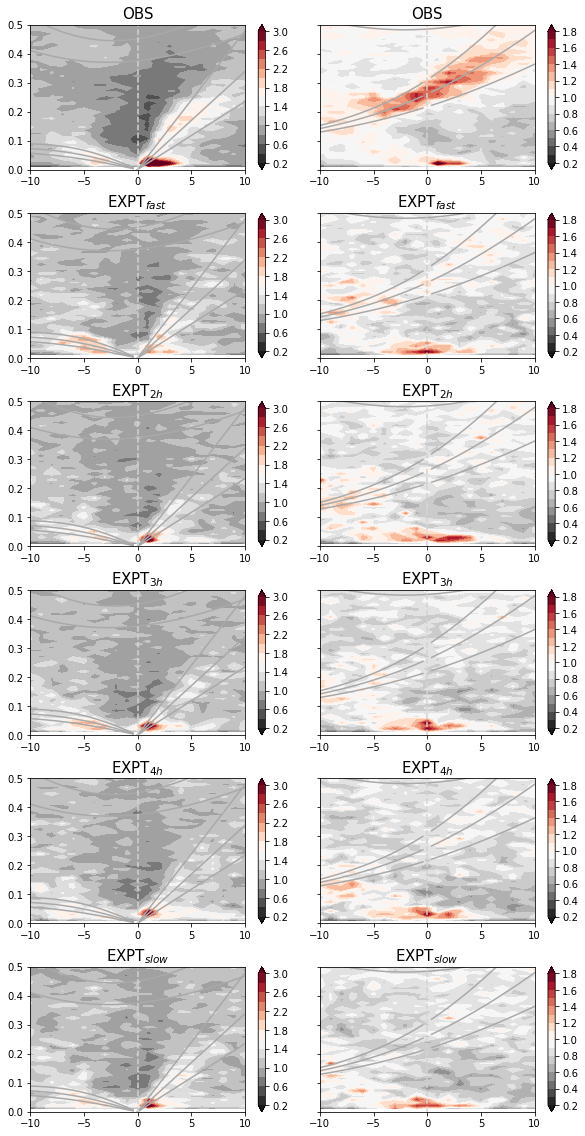

In [10]:
f, ax = plt.subplots(6, 2, sharey=True, figsize=(10,20),gridspec_kw = {'wspace':0.08, 'hspace':0.3})
fnt=15
plot_normalized_symmetric_spectrum(symComponent_obs, ax[0,0])
plot_normalized_asymmetric_spectrum(asymComponent_obs, ax[0,1])
ax[0,0].set_title("OBS", fontsize=fnt)
ax[0,1].set_title("OBS", fontsize=fnt)


plot_normalized_symmetric_spectrum(symComponent_fast, ax[1,0])
plot_normalized_asymmetric_spectrum(asymComponent_fast, ax[1,1])
ax[1,0].set_title("EXPT$_{fast}$", fontsize=fnt)
ax[1,1].set_title("EXPT$_{fast}$", fontsize=fnt)

plot_normalized_symmetric_spectrum(symComponent_2h, ax[2,0])
plot_normalized_asymmetric_spectrum(asymComponent_2h, ax[2,1])
ax[2,0].set_title("EXPT$_{2h}$", fontsize=fnt)
ax[2,1].set_title("EXPT$_{2h}$", fontsize=fnt)

plot_normalized_symmetric_spectrum(symComponent_3h, ax[3,0])
plot_normalized_asymmetric_spectrum(asymComponent_3h, ax[3,1])
ax[3,0].set_title("EXPT$_{3h}$", fontsize=fnt)
ax[3,1].set_title("EXPT$_{3h}$", fontsize=fnt)

plot_normalized_symmetric_spectrum(symComponent_4h, ax[4,0])
plot_normalized_asymmetric_spectrum(asymComponent_4h, ax[4,1])
ax[4,0].set_title("EXPT$_{4h}$", fontsize=fnt)
ax[4,1].set_title("EXPT$_{4h}$", fontsize=fnt)

plot_normalized_symmetric_spectrum(symComponent_slow, ax[5,0])
plot_normalized_asymmetric_spectrum(asymComponent_slow, ax[5,1])
ax[5,0].set_title("EXPT$_{slow}$", fontsize=fnt)
ax[5,1].set_title("EXPT$_{slow}$", fontsize=fnt)

#Saving figure
figname="Figure_05"

plt.savefig('/fs3/home/bgoswami/work/20220908_Andrea/FIGURES_v1.0/'+str(figname)+'.svg', format="svg",transparent=True, dpi=1200)
!rsvg-convert -f pdf -o /fs3/home/bgoswami/work/20220908_Andrea/FIGURES_v1.0/{figname}.pdf /fs3/home/bgoswami/work/20220908_Andrea/FIGURES_v1.0/{figname}.svg
plt.show()
